In [1]:
#importing required modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import anderson, wilcoxon, ttest_ind

In [2]:
#reading allignment scores (these are the already filtered data)
alignment_scores=pd.read_csv('../../data/alignment_scores.csv',index_col=0)
alignment_scores.head(n=3)

,chr_id,scf_id,upstream_score,numt_score,downstream_score
0,14.0,GL019308,-455.0,-455.0,-455.0
1,14.0,GL018741,-91.0,42.0,-87.0
2,14.0,GL018705,-94.0,105.0,-81.0


In [3]:
#data preparation for visualisation
def dataprep(row):
    global merged
    merged.append([row['chr_id'],row['scf_id'],'upstream flanking',row['upstream_score']])
    merged.append([row['chr_id'],row['scf_id'],'numt',row['numt_score']])
    merged.append([row['chr_id'],row['scf_id'],'downstream flanking',row['downstream_score']])
    
merged=[]    
alignment_scores.apply(dataprep,axis=1)
df=pd.DataFrame(merged)
df.columns=['chr_id','scf_id','region','Alignment score']
df['chr_id']=df['chr_id'].apply(lambda chr_id:str(int(chr_id)))
df.head(n=3)

,chr_id,scf_id,region,Alignment score
0,14,GL019308,upstream flanking,-455.0
1,14,GL019308,numt,-455.0
2,14,GL019308,downstream flanking,-455.0


In [4]:
#create a function for the statistical annotation of the graph
def annot_stat(star, x1, x2, y, h, ax=None):
    ax = plt.gca() if ax is None else ax
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, star, ha='center', va='bottom', color='k',fontsize=20)

In [5]:
#sampling and statistics
def statistics(varA,varB):
    np.random.seed(1)
    if len(varA)<len(varB):
        varB=np.random.choice(varB,size=len(varA),replace=True)
    else:
        varA=np.random.choice(varA,size=len(varB),replace=True)
    normA=anderson(varA)
    statA=normA[0]
    critvalA=normA[1][2]
    
    normB=anderson(varB)
    statB=normB[0]
    critvalB=normB[1][2]
    
    if (statA > critvalA) or (statB > critvalB):
        significance = wilcoxon(varA,varB)
    else:
        significance = ttest_ind(varA,varB)
    return significance[1]

In [6]:
#statistical analysis of alignment scores
up_vs_numt=statistics(
    df.loc[df['region']=='upstream flanking']['Alignment score'],
    df.loc[df['region']=='numt']['Alignment score']
)
down_vs_numt=statistics(
    df.loc[df['region']=='downstream flanking']['Alignment score'],
    df.loc[df['region']=='numt']['Alignment score']
)
print(up_vs_numt,down_vs_numt)

6.744562482906104e-25 3.361326861859388e-29


In [7]:
#reading RM data and prepare it for statistical anylsis and visualization
RMresult=pd.read_csv('../../data/RMResults.csv',index_col=0)
RMresult['Chr or Scf']=RMresult['qry_id'].apply(lambda qry_id:qry_id.split('_')[1][:3])
RMresult['region']=RMresult['qry_id'].apply(lambda qry_id:qry_id.split('_')[1][3:].lower())
RMresult['seq_len']=RMresult['qry_id'].apply(lambda item:int(item.split(':')[1].split('_')[0].split('-')[1])-
                        int(item.split(':')[1].split('_')[0].split('-')[0]))
RMresult['Repeat coverage (%)']=((RMresult['qry_width']-1)/RMresult['seq_len'])*100
RMresult=RMresult[['Chr or Scf','region','Repeat coverage (%)']]
flanking_fil=RMresult['region']!='numt'
RMresult=RMresult[flanking_fil]
RMresult.head(n=3)

,Chr or Scf,region,Repeat coverage (%)
1,Chr,down,7.807309
2,Chr,down,7.413249
3,Chr,down,7.366771


In [8]:
#statistical anylsis of RM data
upstream_fil=RMresult['region']=='up'
chr_fil=RMresult['Chr or Scf']=='Chr'
upstream_sig=statistics(
    RMresult[upstream_fil][chr_fil]['Repeat coverage (%)'],
    RMresult[upstream_fil][~chr_fil]['Repeat coverage (%)']
)
downstream_sig=statistics(
    RMresult[~upstream_fil][chr_fil]['Repeat coverage (%)'],
    RMresult[~upstream_fil][~chr_fil]['Repeat coverage (%)']
)
print(upstream_sig,downstream_sig)

0.9774029576586073 0.18750967305946242


/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_28682/1449939770.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  RMresult[upstream_fil][chr_fil]['Repeat coverage (%)'],
/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_28682/1449939770.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  RMresult[upstream_fil][~chr_fil]['Repeat coverage (%)']
/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_28682/1449939770.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  RMresult[~upstream_fil][chr_fil]['Repeat coverage (%)'],
/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_28682/1449939770.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  RMresult[~upstream_fil][~chr_fil]['Repeat coverage (%)']


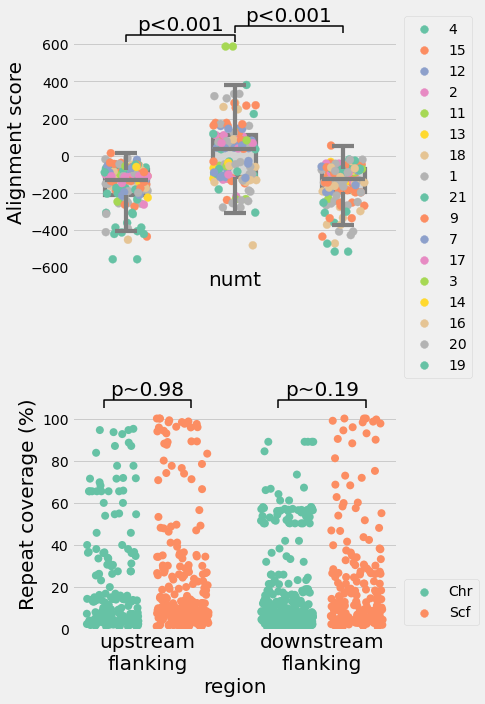

In [10]:
#visualization
plt.style.use('fivethirtyeight')
fig,axs=plt.subplots(2,1,figsize=(7,10))
#boxplots and stripplot in axs[0]##############################################################################
np.random.seed(1)
subdf=df.loc[np.random.choice(np.arange(0,len(df)),size=400)]
sns.boxplot(
    x='region',y='Alignment score',data=subdf,
    linewidth=4.2,
    color='lightgrey',
    fliersize=0,
    width=.4,
    zorder=2,
    ax=axs[0]
)
sns.stripplot(
    x='region',y='Alignment score',data=subdf,
    linewidth=.3,
    size=8,
    hue='chr_id',
    palette="Set2",
    edgecolor=None,
    jitter=.2,
    zorder=1,
    ax=axs[0]
)
axs[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
annot_stat('p<0.001',0,1,max(subdf.loc[subdf['region']=='numt']['Alignment score'])-400,40,axs[0])
annot_stat('p<0.001',2,1,max(subdf.loc[subdf['region']=='numt']['Alignment score'])-350,40,axs[0])
axs[0].set_ylim(-600,750)
axs[0].set_xticklabels(['','numt',''],fontsize=20)
axs[0].set_ylabel('Alignment score',fontsize=20)
axs[0].set_xlabel('',fontsize=20)
#stripplot in axs[1]###########################################################################################
sns.stripplot(
    x='region',
    y='Repeat coverage (%)',
    data=RMresult,
    hue='Chr or Scf',
    dodge=True,
    palette="Set2",
    jitter=.3,
    size=8,
    order=['up','down']
)
annot_stat(f'p~{round(downstream_sig,2)}',0.75,1.25,105,4,axs[1])
annot_stat(f'p~{round(upstream_sig,2)}',-.25,.25,105,4,axs[1])
axs[1].set_ylim(0,119)
axs[1].legend(bbox_to_anchor=(1.02, .2), loc='upper left', borderaxespad=0)
axs[1].set_xticklabels(['upwnstream\nflanking','downstream\nflanking'],fontsize=20)
axs[1].set_ylabel('Repeat coverage (%)',fontsize=20)
axs[1].set_xticklabels(['upstream\nflanking','downstream\nflanking'],fontsize=20)
axs[1].set_xlabel('region',fontsize=20)
plt.tight_layout()
plt.savefig('../../results/deep_anaylsis_combined.png',dpi=400)